# Geostatistical Estimation Tutorial in R for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin, 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

A tutorial/demonstration of spatial estimation with inverse distance and ordinary kriging untilizing the gstat package by Pedesma, E. The docs are at https://cran.r-project.org/web/packages/gstat/index.html.  I found Pedesma's Meuse tutorial very helpful (https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf).  Also, appreciation to Pebesma for assistance through answering questions. For this demonstration we use a 200 well 2D porosity dataset (file: 2D_MV_200Wells.csv) that may be found at https://github.com/GeostatsGuy/GeoDataSets.  I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to R for the engineering undergraduate students. It is assumed that students have no previous R nor geostatistics experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes.

#### Load the required libraries


In [1]:
library(gstat)                                 # geostatistical methods by Edzer Pebesma
library(sp)                                    # spatial points addition to regular data frames
library(plyr)                                  # manipulating data by Hadley Wickham 

Warning message:
"package 'gstat' was built under R version 3.4.3"Warning message:
"package 'sp' was built under R version 3.4.3"Warning message:
"package 'plyr' was built under R version 3.4.3"

If you get a package error, you may have to first go to "Tools/Install Packages..." to install these packages. Just type in the names one at a time into the package field and install.  The package names should autocomplete (helping you make sure you got the package name right), and the install process is automatic, with the possibility of installing other required dependency packages.  Previously, I had an issue with packages not being found after install that was resolved with a reboot.

#### Specify the grid parameters

These parameters described the 2D regular grid that we will estimate on.  This is based on the Geo-DAS grid specification used in GSLIB, Geostatistical Library (Deutsch and Journel, 1998).

In [2]:
nx = 400                                       # number of cells in the x direction
ny = 400                                       # number of cells in the y direction
xmin = 5.0                                     # x coordinate of lower, left cell center 
ymin = 5.0                                     # y coordinate of lower, left cell center 
xsize = 10.0                                   # extent of cells in x direction
ysize = 10.0                                   # extent of cells in y direction

These parameters will be used by a function we define below to build a 2D array of cell center locations to indicate the locations of subsequent estimates.

#### Declare functions

I was surprised that there isn't a built-in method to transform a dataframe column or data vector to standard normal, Gaussian with a mean of zero, $\overline{x} = 0.0$ and a standard deviation $\sigma = 1.0$.  I found this function by Ashton Shortridge (2008) and included it here.  Just apply with the raw data as a vector, $x$, and it returns an object with the normal score values as a member vector, '[my_transform_object]$nscore'. 

In [4]:
nscore <- function(x) {                        # by Ashton Shortridge, 2008
  # Takes a vector of values x and calculates their normal scores. Returns 
  # a list with the scores and an ordered table of original values and
  # scores, which is useful as a back-transform table. See backtr().
  nscore <- qqnorm(x, plot.it = FALSE)$x  # normal score 
  trn.table <- data.frame(x=sort(x),nscore=sort(nscore))
  return (list(nscore=nscore, trn.table=trn.table))
}

This function builds a spatial points dataframe with the locations for estimation / simulation based on the Geo-DAS format that utilizes the parameters declared above.   


In [6]:
addcoord <- function(nx,xmin,xsize,ny,ymin,ysize) { # Michael Pyrcz, March, 2018                      
  # makes a 2D dataframe with coordinates based on GSLIB specification
  coords = matrix(nrow = nx*ny,ncol=2)
  ixy = 1
  for(iy in 1:nx) {
    for(ix in 1:ny) {
      coords[ixy,1] = xmin + (ix-1)*xsize  
      coords[ixy,2] = ymin + (iy-1)*ysize 
      ixy = ixy + 1
    }
  }
  coords.df = data.frame(coords)
  colnames(coords.df) <- c("X","Y")
  coordinates(coords.df) =~X+Y
  return (coords.df)

}  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).

In [7]:
setwd("C:/PGE337")

You will have to change this on Mac (e.g. "~/PGE").  If stuck consider using the GUI to set the working directory. Navigate to the working folder in 'Files' and then go to 'Files/More/Set As Working Directory' in the files pane to the right.  You can then copy the command from the console.

#### Read the data table

Copy the 2D_MV_200Wells.csv comma delimited file from https://github.com/GeostatsGuy/GeoDataSets to your working directory.

In [8]:
mydata = read.csv("2D_MV_200Wells.csv")          # read in comma delimited data file

Let's visualize the first several rows of our data so we can make sure we successfully loaded the data file.

In [9]:
head(mydata)                                   # preview first several rows in the console

X,Y,facies_threshold_0.3,porosity,permeability,acoustic_impedance
565,1485,1,0.1184,6.170,2.009
2585,1185,1,0.1566,6.275,2.864
2065,2865,2,0.1920,92.297,3.524
3575,2655,1,0.1621,9.048,2.157
1835,35,1,0.1766,7.123,3.979
3375,2525,1,0.1239,1.468,2.337


The columns are variables with variable names at the top and the rows are samples.

#### Data preparation and cleaning

First, we must convert the dataframe to a spatial points dataframe.  We do this by defining the $X$ and $Y$ coordinates.  First we check the class to demonstrate that we have a dataframe, then we define the coordinates and check again and confirm that the dataframe object has upgraded to a spatial points dataframe.

In [10]:
class(mydata)                                  # confirms that it is a dataframe
coordinates(mydata) = ~X+Y                     # indicate the X, Y spatial coordinates

[1] "data.frame"

Let's check the dataset by producing summary statistics and visualizing the first several samples' spatial coordinates.

In [11]:
summary(mydata)                                # confirms a spatial points dataframe
head(coordinates(mydata))                      # check the first several coordinates

Object of class SpatialPointsDataFrame
Coordinates:
  min  max
X  25 3955
Y  35 3995
Is projected: NA 
proj4string : [NA]
Number of points: 200
Data attributes:
 facies_threshold_0.3    porosity       permeability      acoustic_impedance
 Min.   :1.00         Min.   :0.0500   Min.   :  0.0158   Min.   :2.009     
 1st Qu.:1.00         1st Qu.:0.1322   1st Qu.:  1.3667   1st Qu.:2.483     
 Median :1.00         Median :0.1502   Median :  4.8255   Median :2.965     
 Mean   :1.33         Mean   :0.1493   Mean   : 25.2875   Mean   :3.000     
 3rd Qu.:2.00         3rd Qu.:0.1742   3rd Qu.: 14.5970   3rd Qu.:3.527     
 Max.   :2.00         Max.   :0.2232   Max.   :463.6410   Max.   :3.984     

,X,Y
1,565,1485
2,2585,1185
3,2065,2865
4,3575,2655
5,1835,35
6,3375,2525


For calculation of the experimental variograms we often work with Gaussian transformed data.  We do this since the variogram of the Gaussian transform of the data is required for sequential Gaussian simulation.  In addition, the Gaussian transform often results in more interpretable variograms.

In [12]:
npor.trn = nscore(mydata$porosity)             # normal scores transform
mydata[["NPorosity"]]<-npor.trn$nscore         # append the normal scores transform 
head(mydata)                                   # check the result

   coordinates facies_threshold_0.3 porosity permeability acoustic_impedance
1  (565, 1485)                    1   0.1184        6.170              2.009
2 (2585, 1185)                    1   0.1566        6.275              2.864
3 (2065, 2865)                    2   0.1920       92.297              3.524
4 (3575, 2655)                    1   0.1621        9.048              2.157
5   (1835, 35)                    1   0.1766        7.123              3.979
6 (3375, 2525)                    1   0.1239        1.468              2.337
   NPorosity
1 -0.9842350
2  0.1700129
3  1.3563117
4  0.3651492
5  0.7306385
6 -0.8505849

We can check the summary statistics of the new variable.

In [13]:
summary(mydata$NPorosity)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.8070 -0.6706  0.0000  0.0000  0.6706  2.8070 

Now let's visualize the original porosity data distribution and also check the distribution of the normal score transform of the porosity data. 

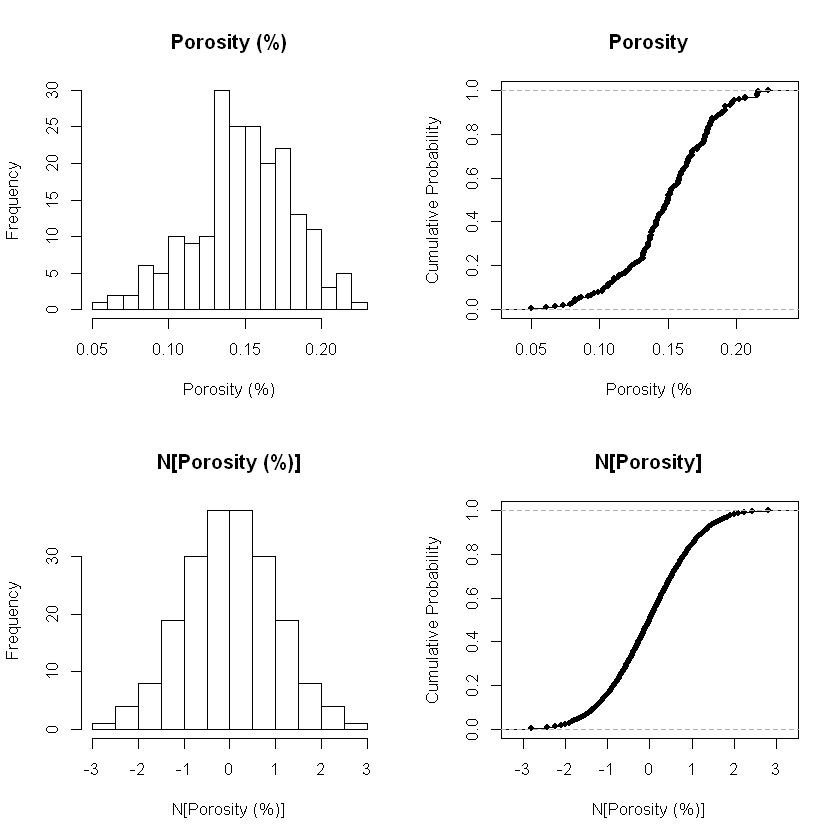

In [14]:
par(mfrow=c(2,2))                              # set up a 2x2 matrix of plots 
hist(mydata$porosity,main="Porosity (%)",xlab="Porosity (%)",nclass = 15) # histogram
plot(ecdf(mydata$porosity),main="Porosity",xlab="Porosity (%",ylab="Cumulative Probability") # CDF
hist(mydata$NPorosity,main="N[Porosity (%)]",xlab="N[Porosity (%)]",nclass = 15) # histogram
plot(ecdf(mydata$NPorosity),main="N[Porosity]",xlab="N[Porosity (%)]",ylab="Cumulative Probability") #CDF

#### Spatial visualization

To assist with infering variogram parameters we should check the spatial arangement of the data. We will look at the general coverage of the data over the area of interest (is there clustering or unsampled areas?), degree of continuity and for potential trends.  Let's start with a simple bubble plot.  We'll declare some plotting parameters first.  These are simply the color thresholds for the porosity estimates and estimation variance (for kriging) 2D output.

In [15]:
cuts = c(.05,.07,.09,.11,.13,.15,.17,.19,.21,.23)
cuts.var = c(0.05,.1,.15,.20,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95)

Now the bubble plot.

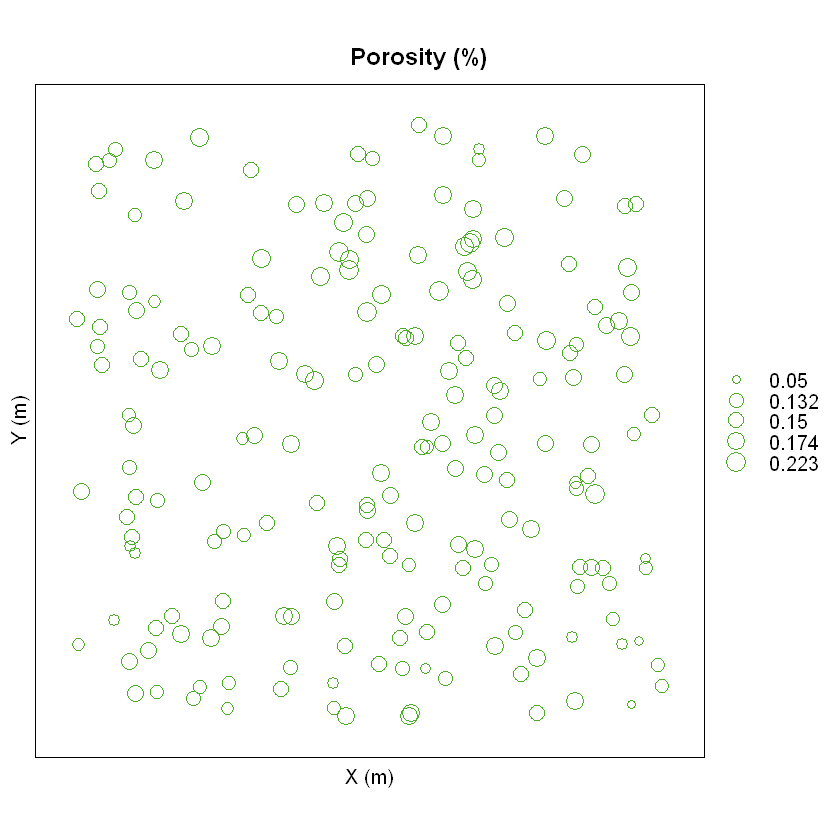

In [16]:
bubble(mydata, "porosity", fill = FALSE, maxsize = 2, main ="Porosity (%)", identify = FALSE,xlab = "X (m)", ylab = "Y (m)")

Also, we could review a porosity data location map. 

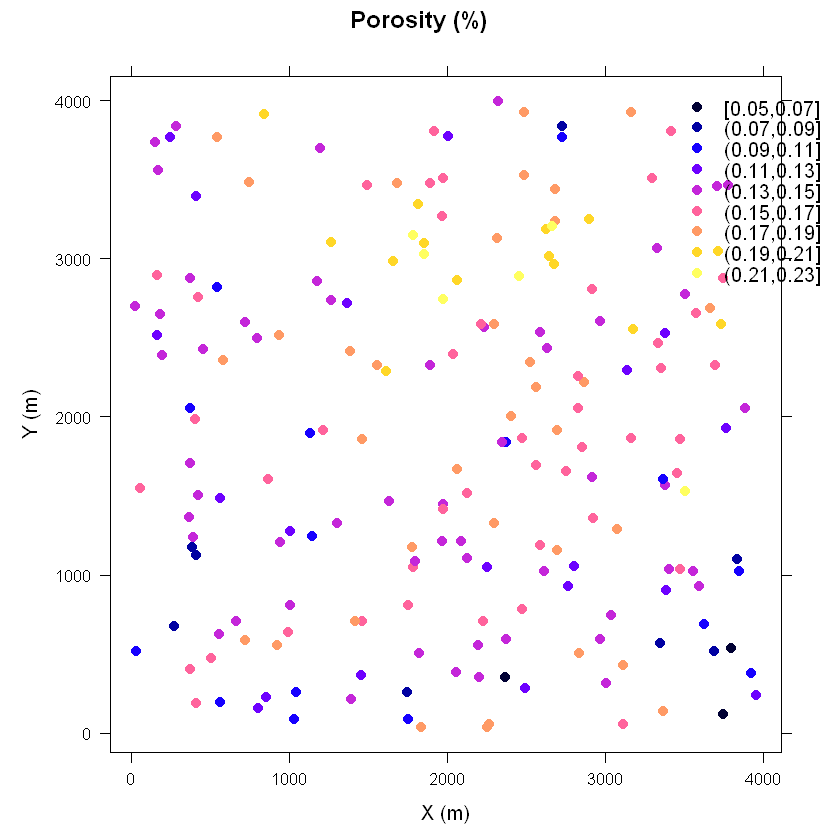

In [20]:
spplot(mydata, "porosity", do.log = TRUE,      # location map of porosity data
       key.space=list(x=.85,y=0.97,corner=c(0,1)),cuts = cuts,
       scales=list(draw=T),xlab = "X (m)", ylab = "Y (m)",main ="Porosity (%)")

We have good coverage of the area of interest (estimation grid) with a nominal, minimal data spacing of about 200 m.  There doesn't seem to be a consistent trend, but there is likely a significant nugget effect, indicated by adjacent high and low values.

#### Modeling spatial continuity

We will use the anisotropic variogram models from last tutorial, note anisotropy is parameterized as vector(azimuth,hratio) in 2D  Recall the c("item1","item2") command concatenates the items into a single vector. For more information about variogram modeling see the previous gstat R tutorial on variogram calculation and modeling.  Let's build the 2D anisotropic variogram model object like this:

In [21]:
por.vm.ani <- vgm(psill = 0.6, "Exp", 800, anis = c(035, 0.5),nugget=0.4)
por.vm.ani                                     # check the variogram model parameters 

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.4,0,0.0,0,0,0,1.0,1
Exp,0.6,800,0.5,35,0,0,0.5,1


In the last tutorial we also designed a custom variogram plots.  The ones provided with the gstat package are somewhat limited. My main concern is the inability to plot the sill, essential for interpretation.  They also cannot be used with matrix of plots.  This requires quite a bit more coding, but for clarity we use these to visualize our anisotropic experimental and model variograms. 

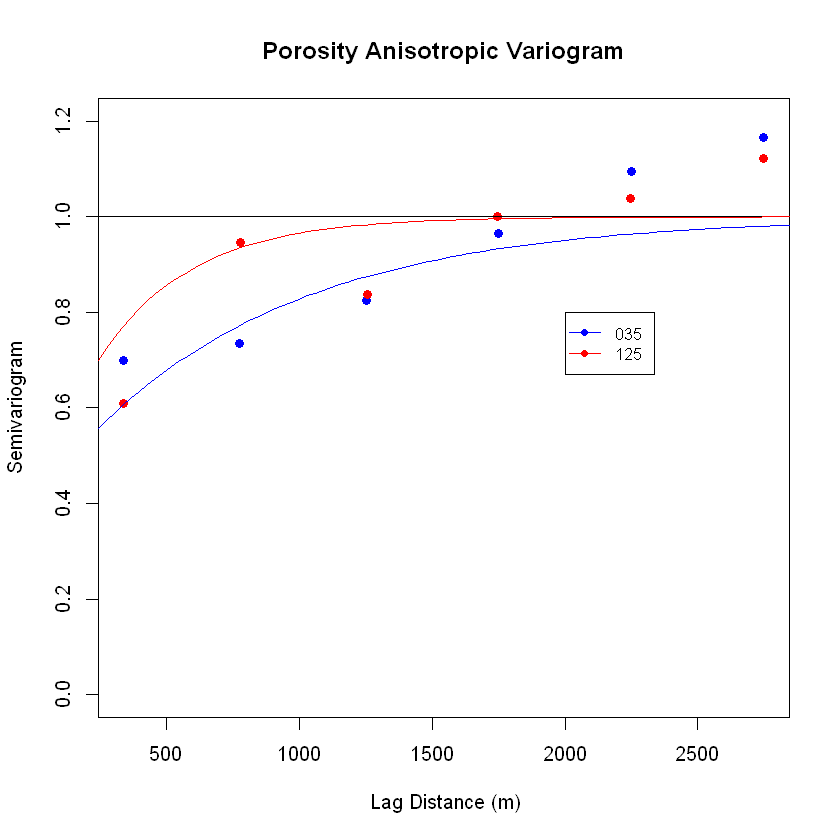

In [22]:
name = c("035","125")                          # make name matrix
color = c("blue","red")                        # make color matrix

por.vg.035 = variogram(NPorosity~1,mydata,cutoff = 3000,width =500,alpha = 35.0,tol.hor=22.5) # 035 directional 
por.vg.125 = variogram(NPorosity~1,mydata,cutoff = 3000,width =500,alpha = 125.0,tol.hor=22.5) # 125 directional

plot(por.vg.035$dist,por.vg.035$gamma,main="Porosity Anisotropic Variogram",xlab="  Lag Distance (m) ",ylab=" Semivariogram ",pch=16,col=color[1],ylim=c(0,1.2))
points(por.vg.125$dist,por.vg.125$gamma,pch=16,col=color[2])
abline(h = 1.0)

unit_vector = c(sin(35*pi/180),cos(35*pi/180),0) # unit vector for 035 azimuth
vm.ani.035 <- variogramLine(por.vm.ani,maxdist=3000,min=0.0001,n=100,dir=unit_vector,covariance=FALSE) # model at 035
lines(vm.ani.035$dist,vm.ani.035$gamma,col=color[1]) # include variogram model 

unit_vector = c(sin(55*pi/180),-1*cos(35*pi/180),0) # unit vector for 125 azimuth
vm.ani.125 <- variogramLine(por.vm.ani,maxdist=3000,min=0.0001,n=100,dir=unit_vector,covariance=FALSE) # model at 125 
lines(vm.ani.125$dist,vm.ani.125$gamma,col=color[2]) # include variogram model
legend(2000,.8,name, cex=0.8, col=color,pch=c(16,16,16),lty=c(1,1,1)) # add legend

#### 2D grid specification 

We have already defined a function that takes the Geo-DAS grid parameters and builds a spatial points dataframe with the estimation locations.  Note this is a cell-centered, regular grid.

In [23]:
coords <- addcoord(nx,xmin,xsize,ny,ymin,ysize) # make a dataframe with all the estimation locations
summary(coords)                                # check the coordinates

Object of class SpatialPoints
Coordinates:
  min  max
X   5 3995
Y   5 3995
Is projected: NA 
proj4string : [NA]
Number of points: 160000

From the summary we can see the number of grid cells, ($n = 160,000$), and the extents of the 2D regular grid, $4,000 \times 4,000$.

#### Inverse distance

Let's start with a very simple spatial estimation method known as inverse distance.

$$ z^*(\bf{u}_{0}) = \sum^{n}_{\alpha=1} \frac{1}{d^{p}} z(\bf{u}_{\alpha}) $$

The neighbouring data are $z(\bf{u}_{\alpha}), \alpha = 1,\ldots,n$.  Note, it is common to enforce unbiasedness through the sum of the weights equal to 0.0 and a small value may be added to the distance, $d$, to avoid divide by 0.0 at data locations.  

The inverse distance method applies weights to neighbouring data equal to the inverse of distance to a user specified power.  The power controls the sensitivity of the estimates to distance from the data values.  A small power ($p=1$) results in low sensitivity and the estimates tend towards the local average.  A high power ($p=3$) results in estimates very sensitive and the estimates vary significantly locally.  For inverse distance estimation, the power is the only control on the resulting spatial continuity.

To demonstrate the influence of power we will try 3 different powers, $p=1,2,3$, to demonstrate the influence of power on the interpolation.  We'll declare some plotting parameters first.  Now the inverse distance method is applied followed by visualization for each power.

In [24]:
porosity.idw.2.0 = idw(porosity~1, idp = 2.0,mydata, coords) # inverse distance power 2.0

[inverse distance weighted interpolation]


We look at the inverse distance estimation object and confirm that it is also a spatial points dataframe.

In [25]:
class(porosity.idw.2.0)                        # check the inverse distance object

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

Then we use the spatial plot method from the gstat package to produce a plot of the estimations over our regular 2D grid. Note that the data show up as `islands' where they depart from the local mean. 

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

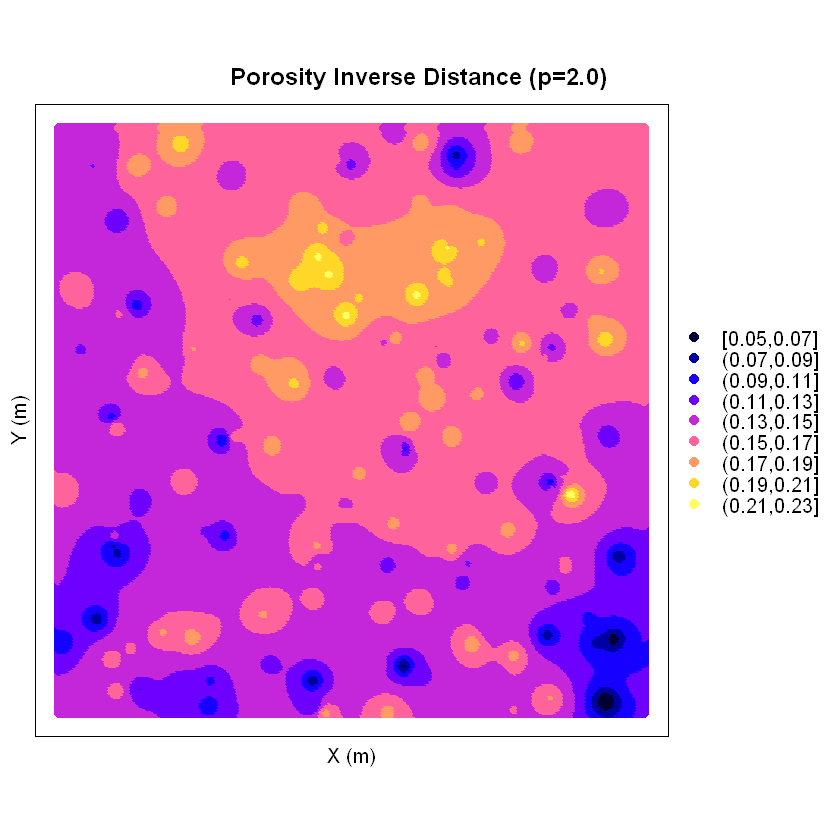

In [26]:
class(porosity.idw.2.0)                        # check the inverse distance object
spplot(porosity.idw.2.0["var1.pred"],main = "Porosity Inverse Distance (p=2.0)", key.space = "right",cuts = cuts,xlab = "X (m)", ylab = "Y (m)")

We started with a power of 2, $p=2$, a common power for inverse distance estimation.  Now let's go to a weaker power, $p=1$, and compare.

[inverse distance weighted interpolation]


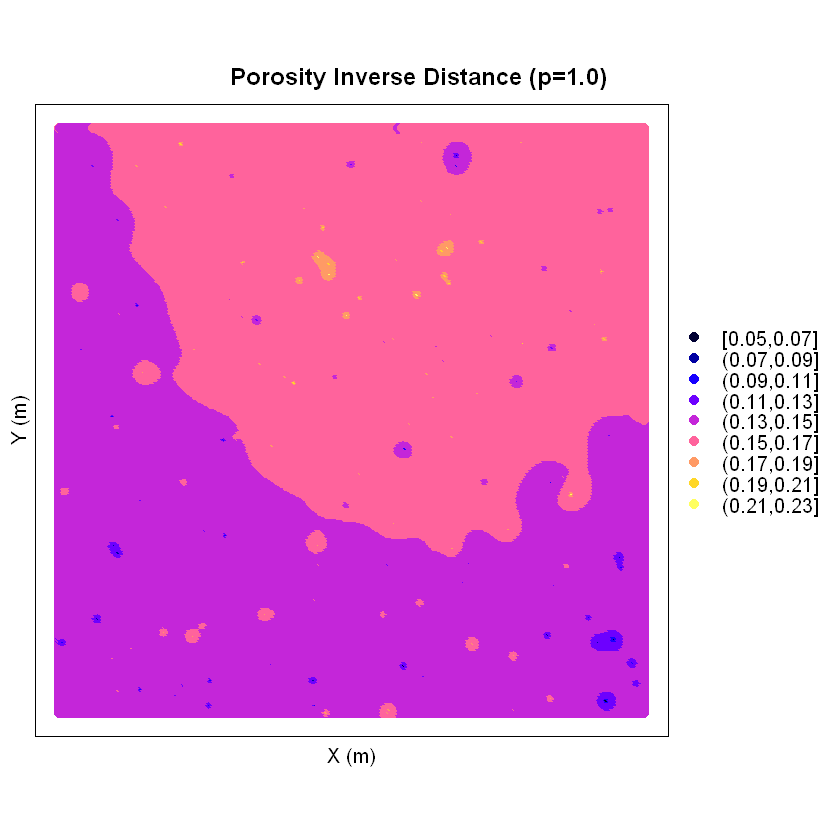

In [27]:
porosity.idw.1.0 = idw(porosity~1, idp = 1.0,mydata, coords) # inverse distance power 1.0
spplot(porosity.idw.1.0["var1.pred"],main = "Porosity Inverse Distance (p=1.0)", key.space = "right",cuts = cuts,xlab = "X (m)", ylab = "Y (m)")

Note that the weaker power results in a less variable, more averaged and less locally specific estimation map.  Now let's try the high power, $p=3$.

[inverse distance weighted interpolation]


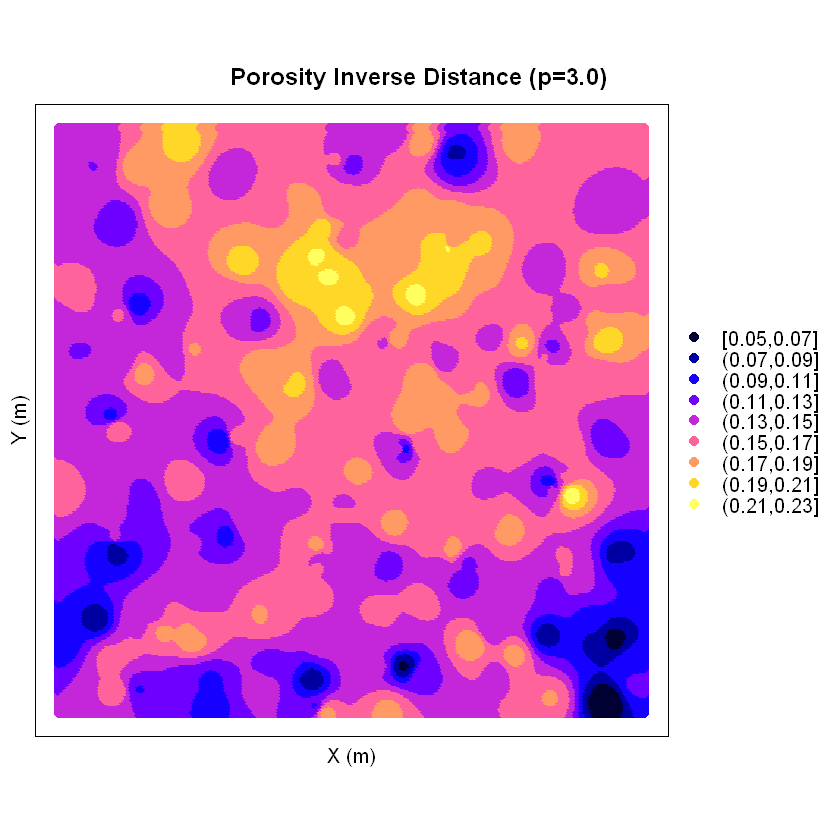

In [28]:
porosity.idw.3.0 = idw(porosity~1, idp = 3.0,mydata, coords) # inverse distance power 3.0
spplot(porosity.idw.3.0["var1.pred"],main = "Porosity Inverse Distance (p=3.0)", key.space = "right",cuts = cuts,xlab = "X (m)", ylab = "Y (m)")

Inverse distance is a simple and useful estimation method, but it does not: 

1. allow for anisotropy unless modified with a custom geometric distance calculation
2. allow for use of a spatial continuity measure calculated from the data
3. provide optimum estimates in any sense
4. provide a measure of uncertainty in the estimate.

To address these limitations we use kriging.

#### Ordinary Kriging

The ordinary kriging estimator is also a linear estimator:

$$ z^*(\bf{u}_{0}) = \sum^{n}_{\alpha=1} \lambda_\alpha z(\bf{u}_{\alpha}) $$

where $\lambda_\alpha, \alpha = 1,\ldots,n$ are the kriging weights calculated with the ordinary kriging system (Isaaks and Strivastava, 1989; Chiles and Delfiner, 2012).

Now let's try some ordinary kriging parameterized with unlimited search constraints.  For the gstat package kriging program, the default is unlimited search, including infinity for the maximum distance to look for neighbouring data, $0$ for minimum number of data to make an estimate, and infinity for maximum number of data per octant.  For clarity, we explicitly set the search parameters as we run the ordinary kriging program. After running kriging we check the resulting output by calculating a summary of the estimates.

In [29]:
porosity.kriged = krige(porosity~1, mydata, coords, model = por.vm.ani,maxdist = Inf,nmin = 0,omax=Inf) # ordinary kriging
summary(porosity.kriged)

Warning message in predict.gstat(g, newdata = newdata, block = block, nsim = nsim, :
"NAs introduced by coercion to integer range"

[using ordinary kriging]


Object of class SpatialPointsDataFrame
Coordinates:
  min  max
X   5 3995
Y   5 3995
Is projected: NA 
proj4string : [NA]
Number of points: 160000
Data attributes:
   var1.pred         var1.var     
 Min.   :0.0500   Min.   :0.0000  
 1st Qu.:0.1399   1st Qu.:0.6107  
 Median :0.1503   Median :0.6461  
 Mean   :0.1491   Mean   :0.6504  
 3rd Qu.:0.1588   3rd Qu.:0.6832  
 Max.   :0.2232   Max.   :0.8954  

Now let's visualize the resulting estimates. Can you see the way ordinary kriging approaches the local, estimated mean away from data locations?  This results in an estimation model with less local islands and more local trends matched to data. 

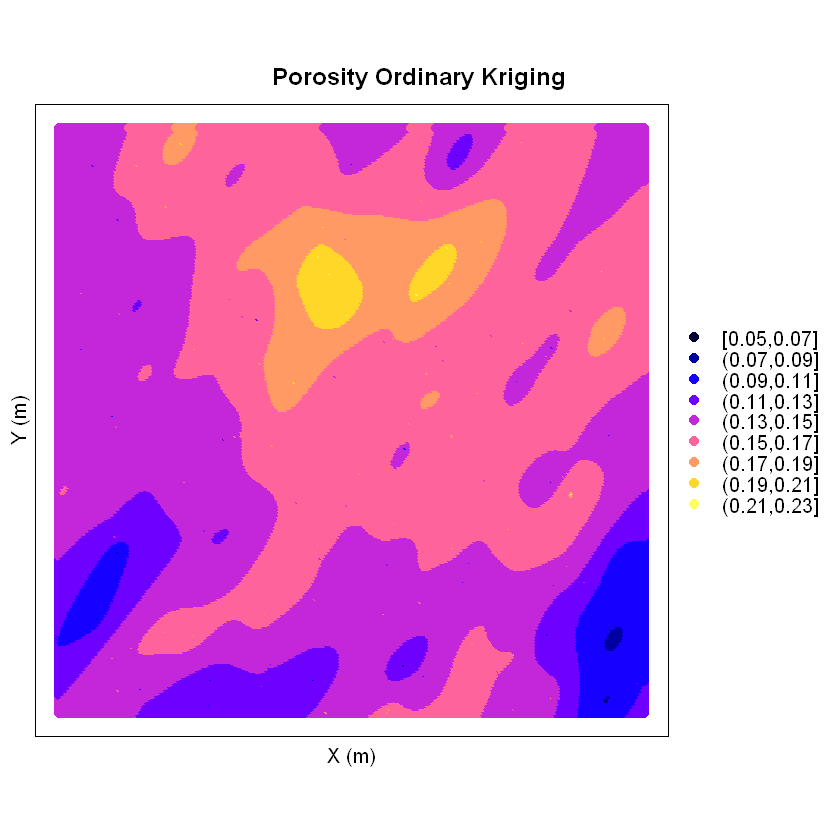

In [30]:
spplot(porosity.kriged["var1.pred"],main = "Porosity Ordinary Kriging", key.space = "right",cuts = cuts,xlab = "X (m)", ylab = "Y (m)")

Another output of kriging is the estimation variance (also known as the kriging variance)(Isaaks and Strivastava, 1989; Chiles and Delfiner, 2012).  It is instructive to visualize the estimation variance to understand locally the uncertainty or accuracy in the estimates (given the decisions of stationary variogram and locally stationary mean).  Note that given sill = 1.0, the maximum estimation variance is 1.0.

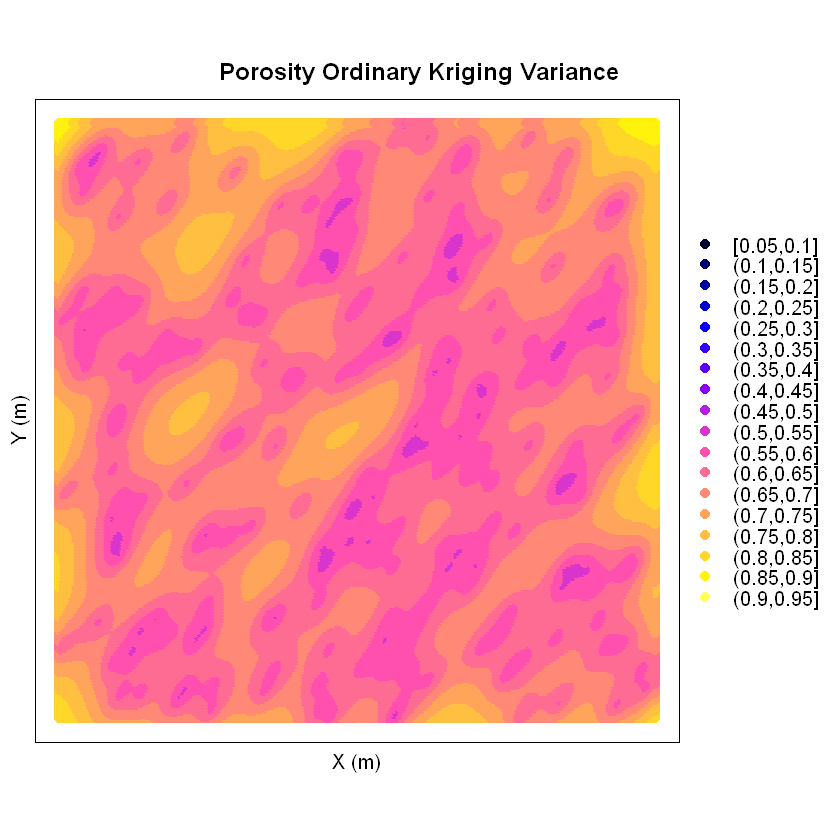

In [31]:
spplot(porosity.kriged["var1.var"],main = "Porosity Ordinary Kriging Variance", key.space = "right",cuts = cuts.var,xlab = "X (m)", ylab = "Y (m)")

Of course estimation does not reproduce the data histogram, there is missing variance.  Let's check that by comparing the original porosity data distribution and kriged estimate distribution.  

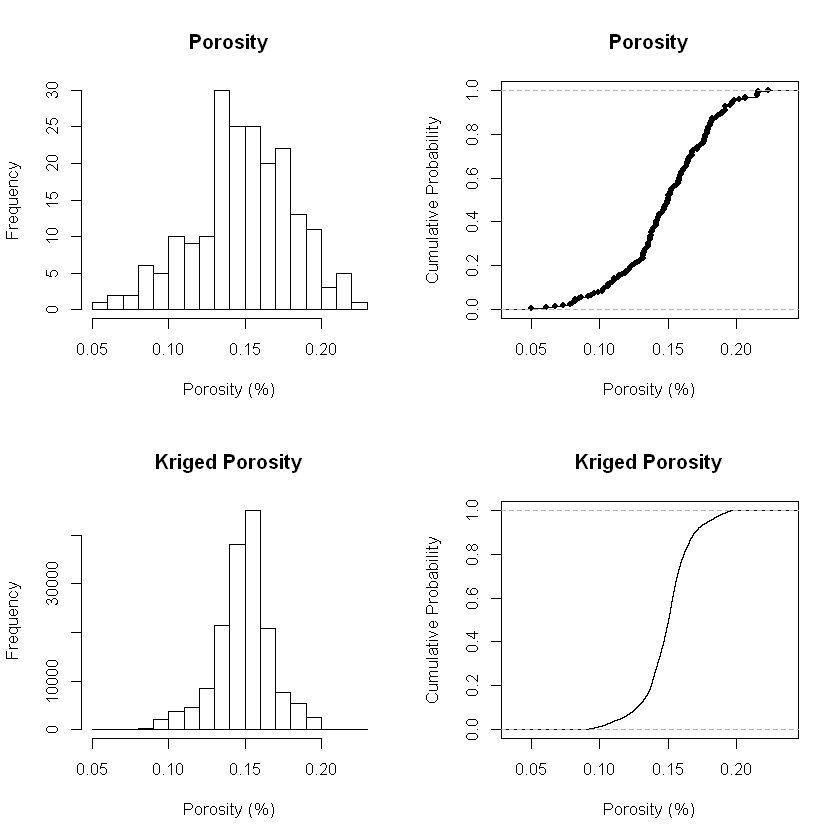

In [32]:
par(mfrow=c(2,2))                              # set up a 2x2 matrix of plots 
hist(mydata$porosity,main="Porosity",xlab="Porosity (%)",nclass = 15) # histogram
plot(ecdf(mydata$porosity),main="Porosity",xlab="Porosity (%)",ylab="Cumulative Probability") # CDF
hist(porosity.kriged$var1.pred,main="Kriged Porosity",xlab="Porosity (%)",nclass = 15) # histogram
plot(ecdf(porosity.kriged$var1.pred),main="Kriged Porosity",xlab="Porosity (%)",ylab="Cumulative Probability") #CDF

It is clear that the kriged porosity values have a lower variance than the original porosity data.

Search limits are helpful to ensure the estimation model completes in a reasonable amount of time and to avoid issues such as the string effect, but can lead to search artifacts.  Let's make some artifacts with a very limited set of search parameters

In [33]:
maxdist = 800                                  # maximum distance to look for data
nmin = 3                                       # minimum number of data for an estimate
omax = 1                                       # maximum number of data per octant    

and then by repeating the kriging calculation.

[using ordinary kriging]


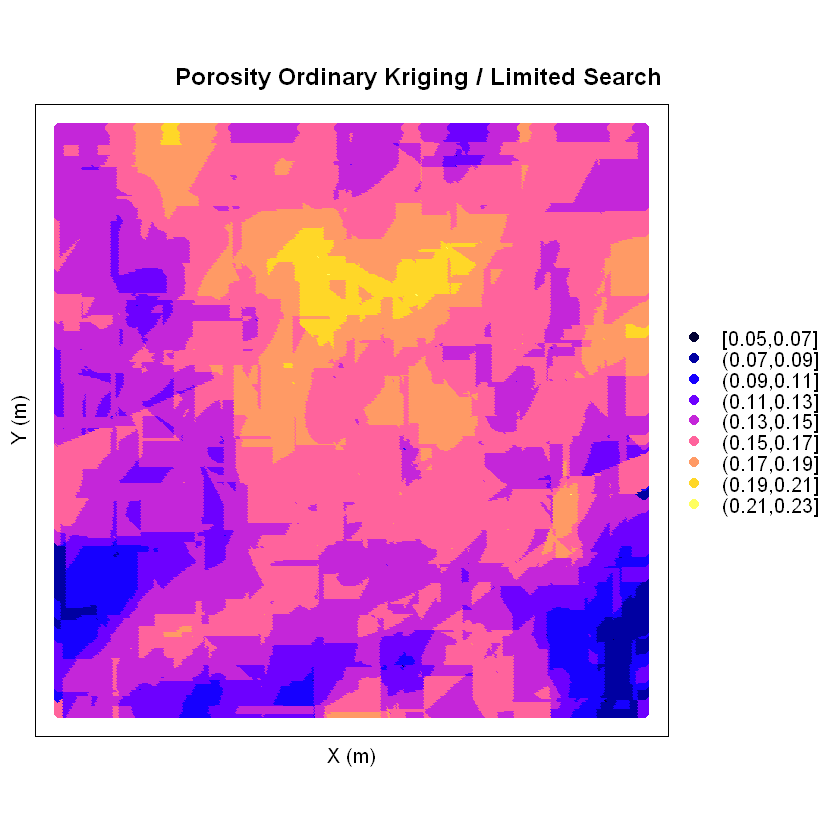

In [34]:
porosity.kriged.sp = krige(porosity~1, mydata, coords, model = por.vm.ani,maxdist = maxdist,nmin = nmin,omax=omax) # ordianry kriging
spplot(porosity.kriged.sp["var1.pred"],main = "Porosity Ordinary Kriging / Limited Search", key.space = "right",cuts = cuts,xlab = "X (m)", ylab = "Y (m)")

Observe the search artifacts (lines and bands) due to too restrictive search.  This is caused mainly by limits on maximum distance resulting in sharp changes in local conditioning data.  

Now, let's remove the nugget effect and krige again once again with unlimited search. First we make a new variogram model without nugget effect, but the same structures and anisotropy as applied previously.  All contribution is removed from nugget effect and attributed to the single exponential structure. 

In [35]:
por.vm.ani.nonugget <- vgm(psill = 1.0, "Exp", 800, anis = c(035, 0.5),nugget=0.0)
por.vm.ani.nonugget  

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0,0,0.0,0,0,0,1.0,1
Exp,1,800,0.5,35,0,0,0.5,1


Now we build another 2D model of kriged estimates.

Warning message in predict.gstat(g, newdata = newdata, block = block, nsim = nsim, :
"NAs introduced by coercion to integer range"

[using ordinary kriging]


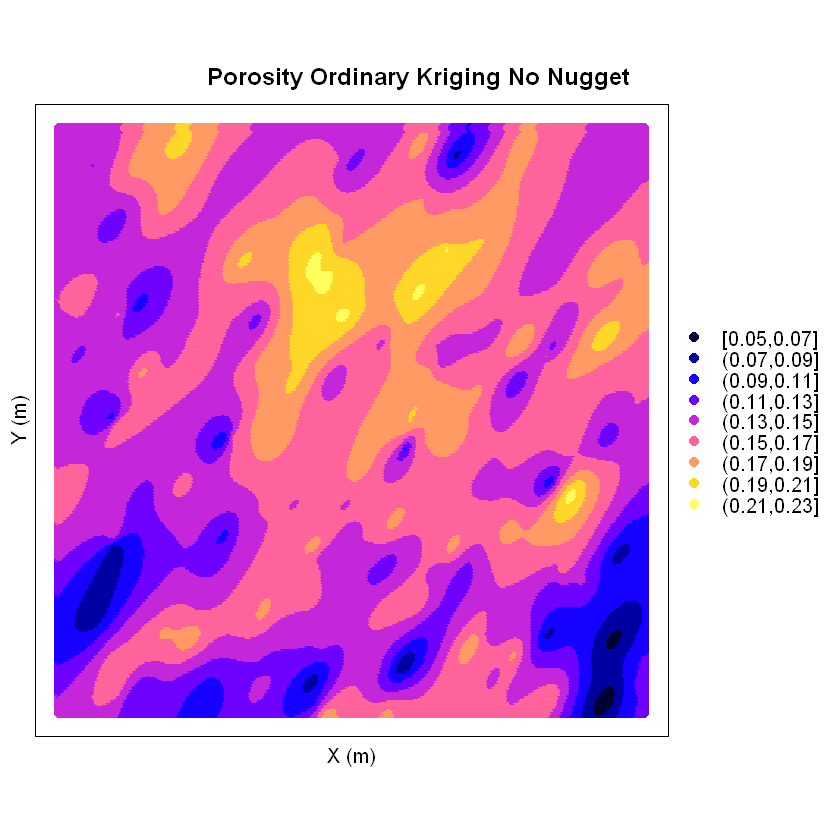

In [36]:
porosity.kriged.nonugget = krige(porosity~1, mydata, coords, model = por.vm.ani.nonugget,maxdist = Inf,nmin = 0,omax=Inf) # ordianry kriging
spplot(porosity.kriged.nonugget["var1.pred"],main = "Porosity Ordinary Kriging No Nugget", key.space = "right",cuts = cuts,xlab = "X (m)", ylab = "Y (m)")

The general result is increaed correlation with neighbouring data, in other words more features imposed by data.  It is quite interesting to compare estimation variance for the no nugget effect with the $40\%$ relative nuggect effect model.

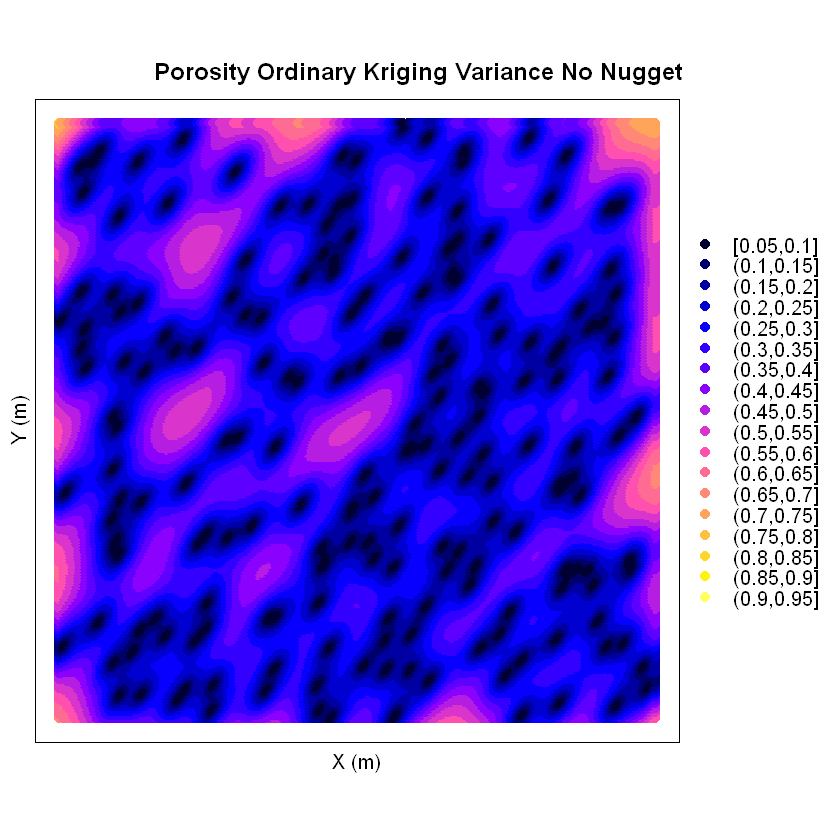

In [37]:
spplot(porosity.kriged.nonugget["var1.var"],main = "Porosity Ordinary Kriging Variance No Nugget", key.space = "right",cuts = cuts.var,xlab = "X (m)", ylab = "Y (m)")

There are so many more tests that one could attempt to gain experience with of spaital estimation.  I'll end here for brevity, but invite you to continue.  Consider, on your own changing the variogram parameters and observe the results.  Also attempt kriging with a trend.

I hope you found this tutorial useful.  I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,


![](c:/PGE337/mjp_signature.png)


Michael Pyrcz, Ph.D., P.Eng.
Associate Professor
The Hildebrand Department of Petroleum and Geosystems Engineering
The University of Texas at Austin